In [ ]:
# Pass an image through the encoder.
# For each axis, get a set of images where the value along the axis is varied according to the assumed prior by
# passing the varied embeddings through the decoder.

# Load the data

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
# Will pass image(s) into encoder
val_trks = load_trks(os.path.join('/data/tracking-nuclear', 'val.trks'))
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done creating Track objects.')

2022-09-01 22:20:51.127840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 22:20:52.054908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5255 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
100%|███████████████████████████████████████████| 27/27 [02:43<00:00,  6.05s/it]


Done creating Track objects.


# Load model

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [4]:
# Load the model
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [5]:
model_name = 'example'
vae = VAE(16, 1, 1e-3, 64, 4, 64)
AE = vae.build_vae_keras_model()
AE.load_weights('/data/models/' + model_name)

2022-09-01 22:26:03.410277: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Get reconstructions

In [135]:
# First, let's get the reconstruction of 'rep' itself

In [6]:
def get_embedding(img, encoder):
    rep = encoder(np.array([img])).mean()
    return rep[0]

In [31]:
def get_recon(rep, decoder):
    recon = decoder(np.array([rep])).mean()
    return recon[0]

In [8]:
def get_axis_travs(axis, rep):
    # rep will be a tf.Tensor
    axis_travs = []
    for std in range(-3, 4):
        mod_rep = np.array(rep)
        mod_rep[axis] = std
        axis_travs.append(tf.convert_to_tensor(mod_rep, dtype='float32'))
    return axis_travs

In [9]:
encoder = AE.get_layer('encoder')
decoder = AE.get_layer('decoder')
img = val_tracks.appearances[2][13][6]

In [10]:
rep = get_embedding(img, encoder)

2022-09-01 22:29:36.042178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [14]:
rep

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-0.10848176, -0.02837071,  0.03516308, -0.06667082, -0.02144269,
       -0.03120672,  0.02262064,  0.052923  ,  0.11814385, -0.0079533 ,
        0.04679003,  0.0427274 , -0.11621921,  0.01224287, -0.00234196,
       -0.05317511], dtype=float32)>

In [11]:
recon = get_recon(rep, decoder)

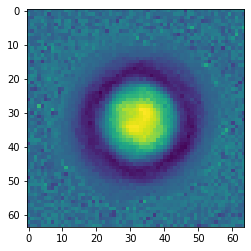

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(recon[0])

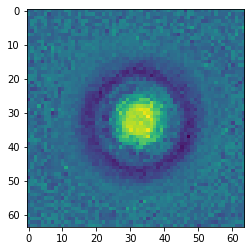

In [15]:
axis = 0
axis_travs = get_axis_travs(axis, rep)
mod_recon = get_recon(axis_travs[0], decoder)
fig, ax = plt.subplots()
ax.imshow(mod_recon[0])

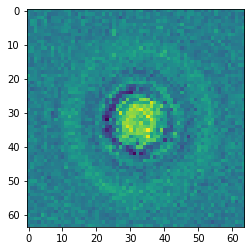

In [16]:
axis = 1
axis_travs = get_axis_travs(axis, rep)
mod_recon = get_recon(axis_travs[0], decoder)
fig, ax = plt.subplots()
ax.imshow(mod_recon[0])

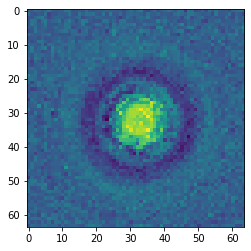

In [17]:
axis = 2
axis_travs = get_axis_travs(axis, rep)
mod_recon = get_recon(axis_travs[0], decoder)
fig, ax = plt.subplots()
ax.imshow(mod_recon[0])

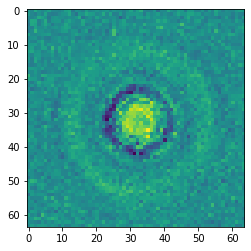

In [19]:
axis = 4
axis_travs = get_axis_travs(axis, rep)
mod_recon = get_recon(axis_travs[0], decoder)
fig, ax = plt.subplots()
ax.imshow(mod_recon[0])

# Why does this look exactly like axis 1 (but maybe greener)?

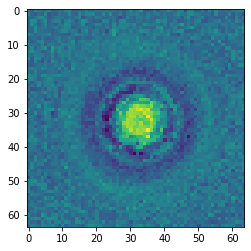

In [30]:
axis = 15
axis_travs = get_axis_travs(axis, rep)
mod_recon = get_recon(axis_travs[0], decoder)
fig, ax = plt.subplots()
ax.imshow(mod_recon[0])

In [ ]:
# Now we just need a way to spit out reconstructions of all 7 std variations for each axis

In [42]:
def get_axis_trav_recons(img, encoder, decoder):
    rep = get_embedding(img, encoder)
    embed_dim = rep.shape[0]
    for axis in range(embed_dim):
        axis_travs = get_axis_travs(axis, rep)
        fig = plt.figure(figsize=(35, 5))
        rows = 1
        columns = 7
        for std in range(-3, 4):
            idx = std + 3
            mod_rep = axis_travs[idx]
            mod_recon = get_recon(mod_rep, decoder)
            fig.add_subplot(rows, columns, idx + 1)
            plt.imshow(mod_recon)
            plt.axis('off')
            plt.title(str(std))
        fig.suptitle("Axis " + str(axis) + " Traversal")

In [14]:
# Should input a random image and see what happens

In [33]:
rep.shape[0]

16

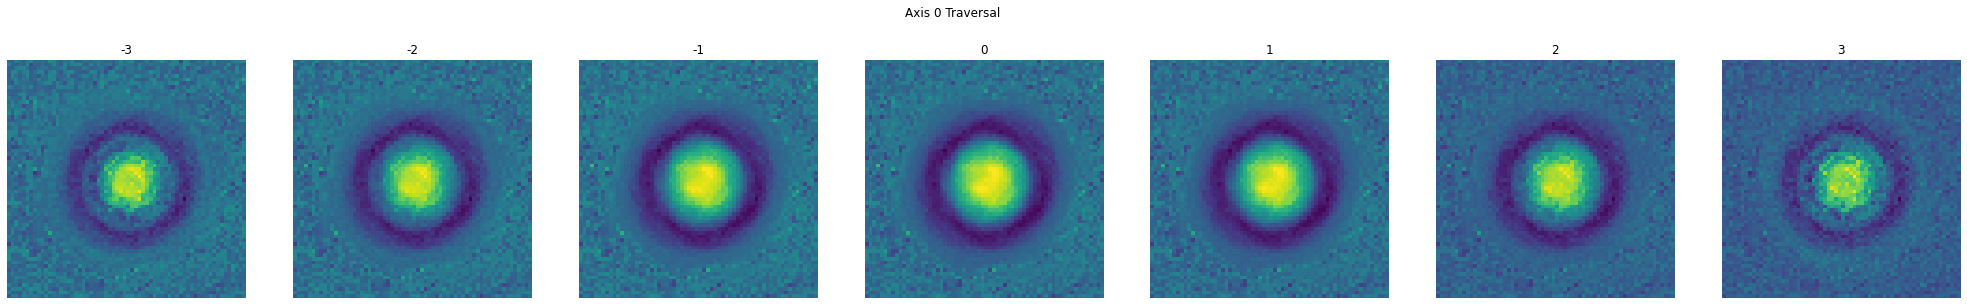

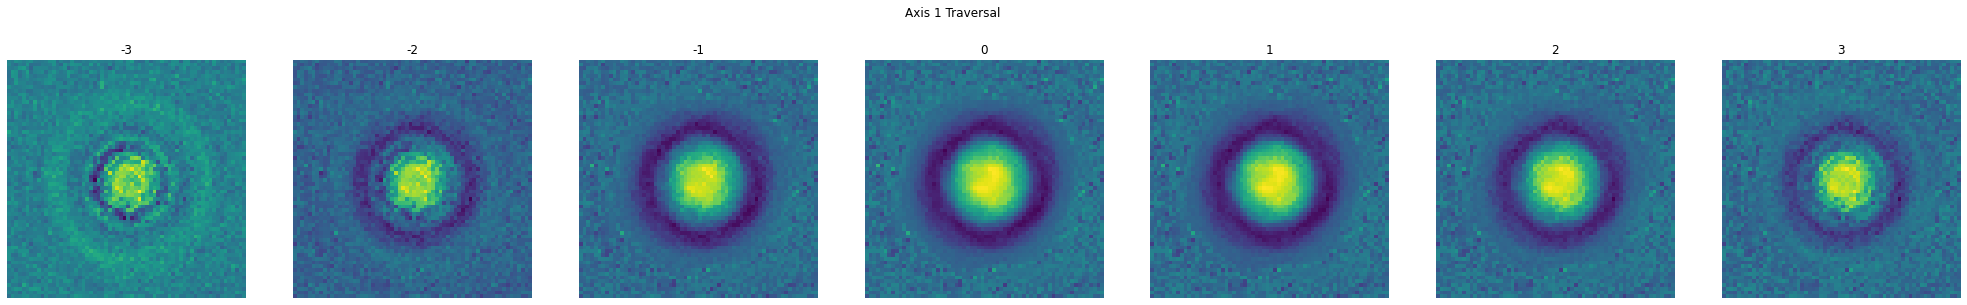

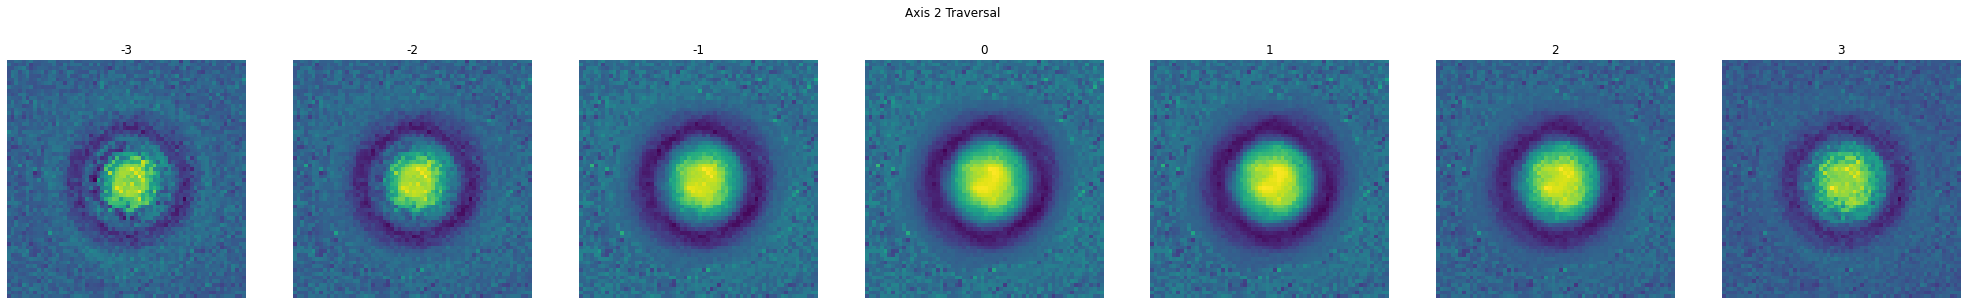

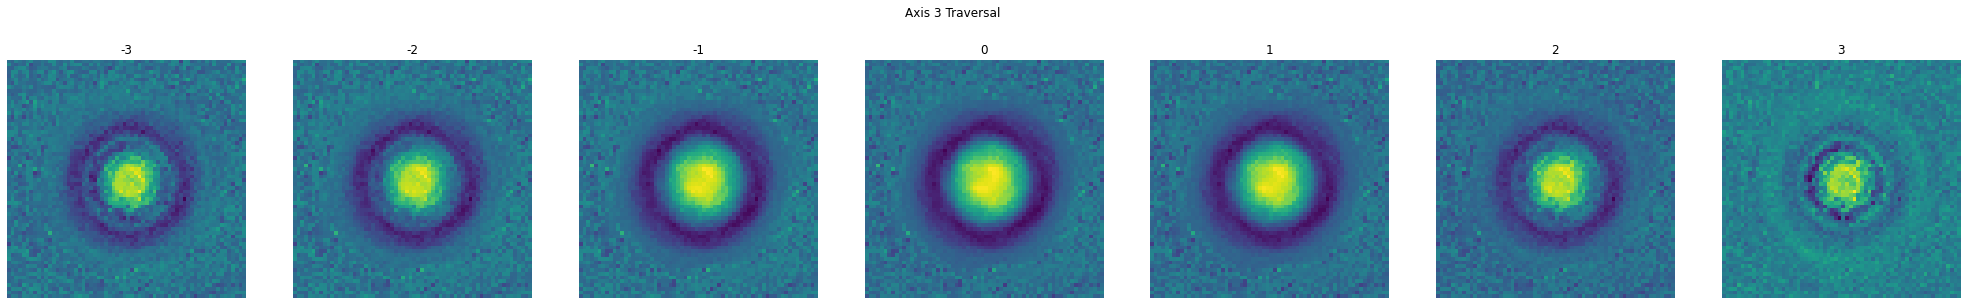

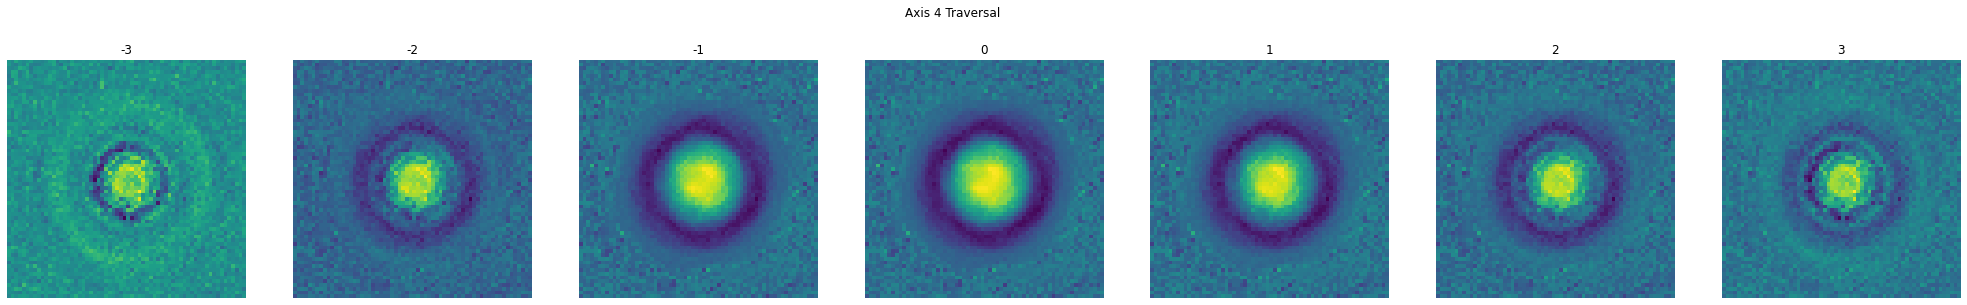

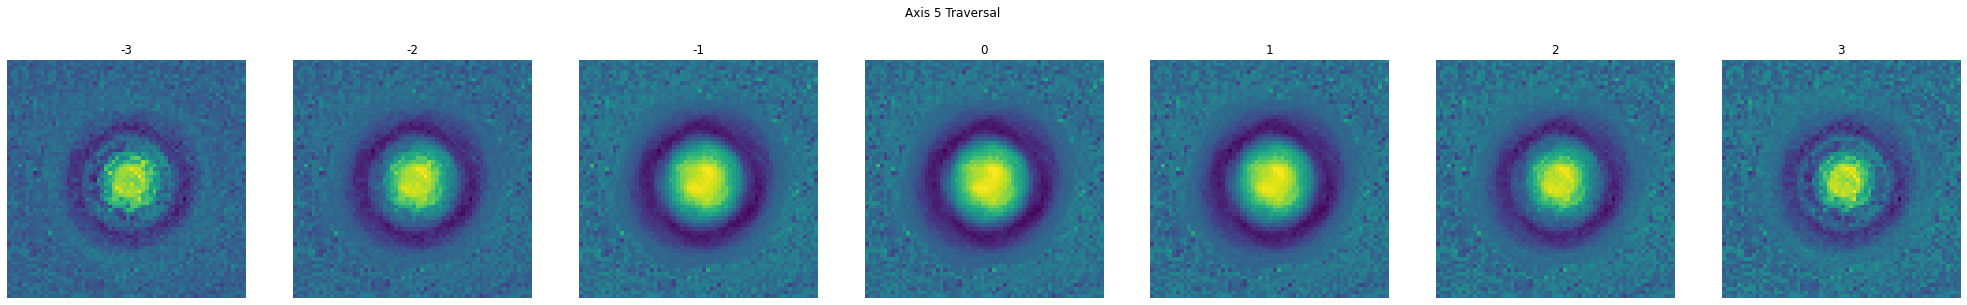

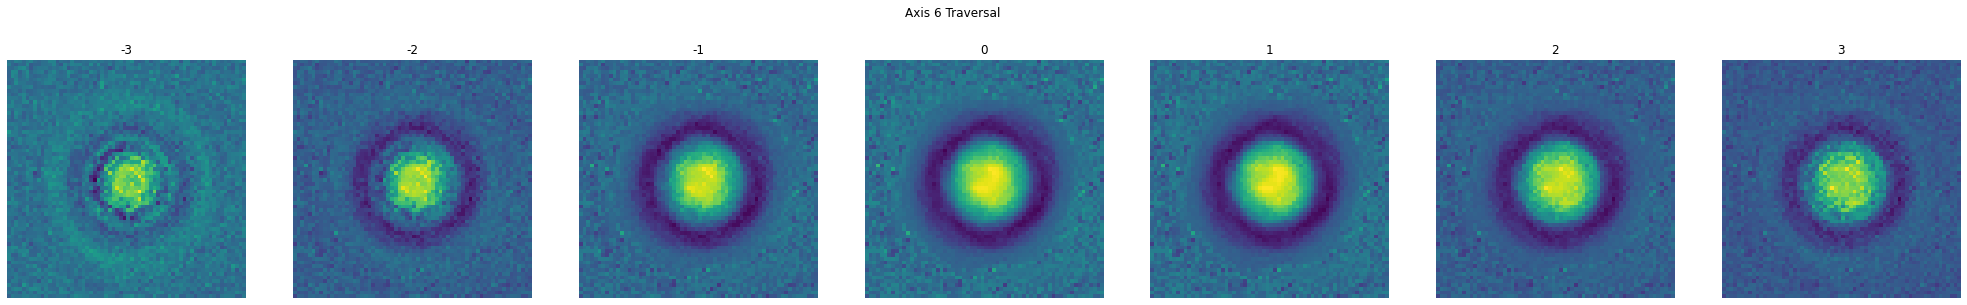

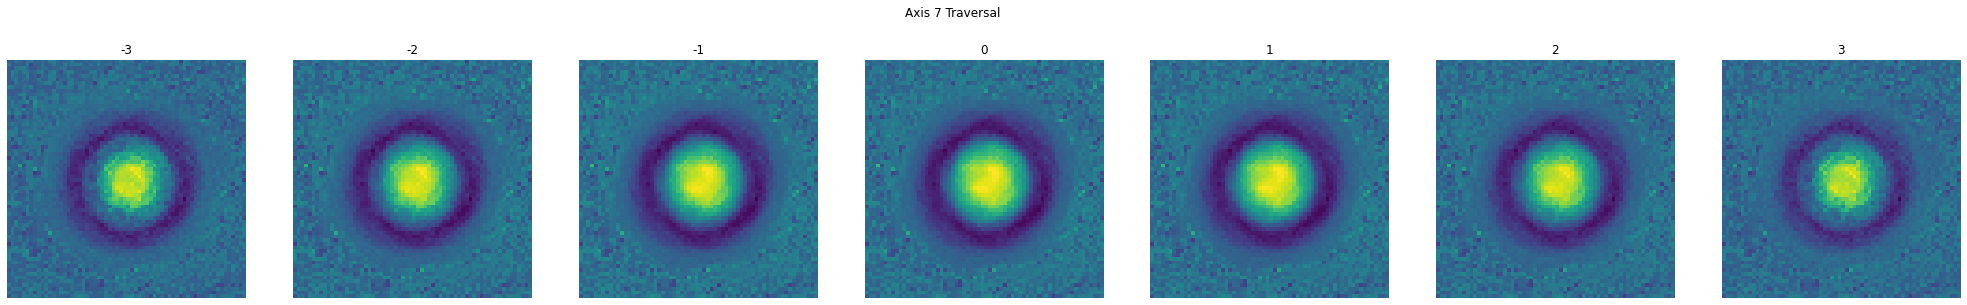

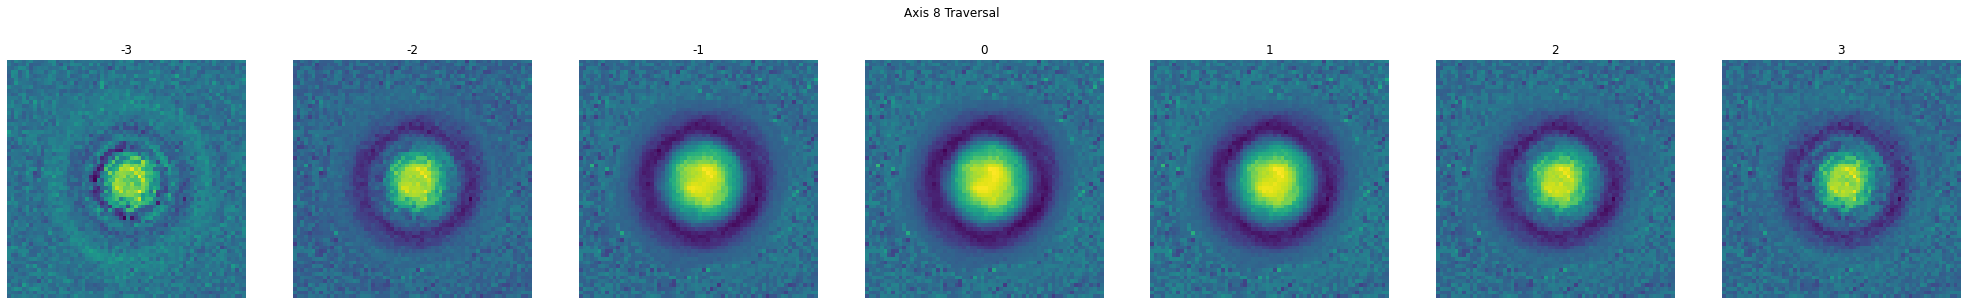

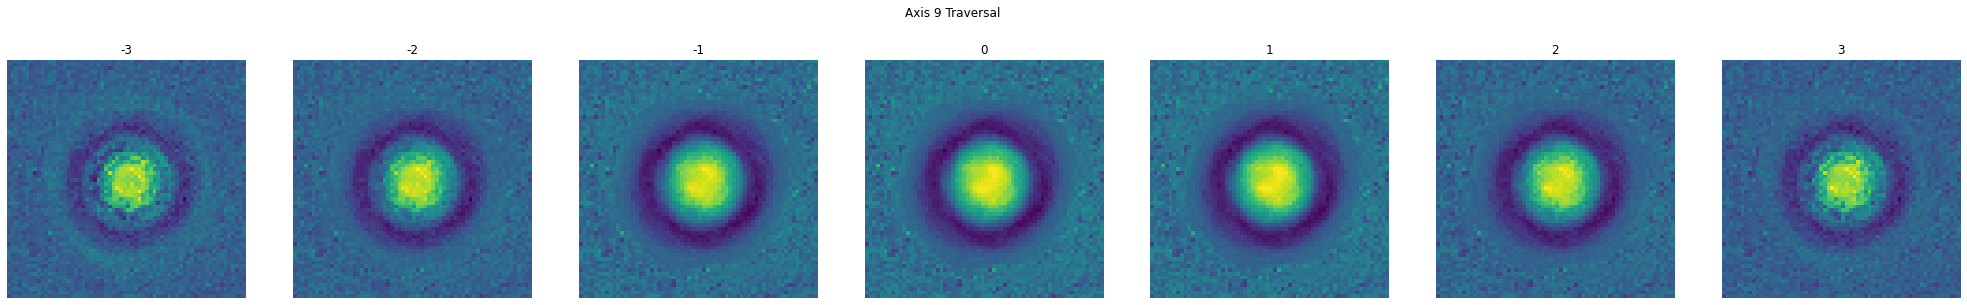

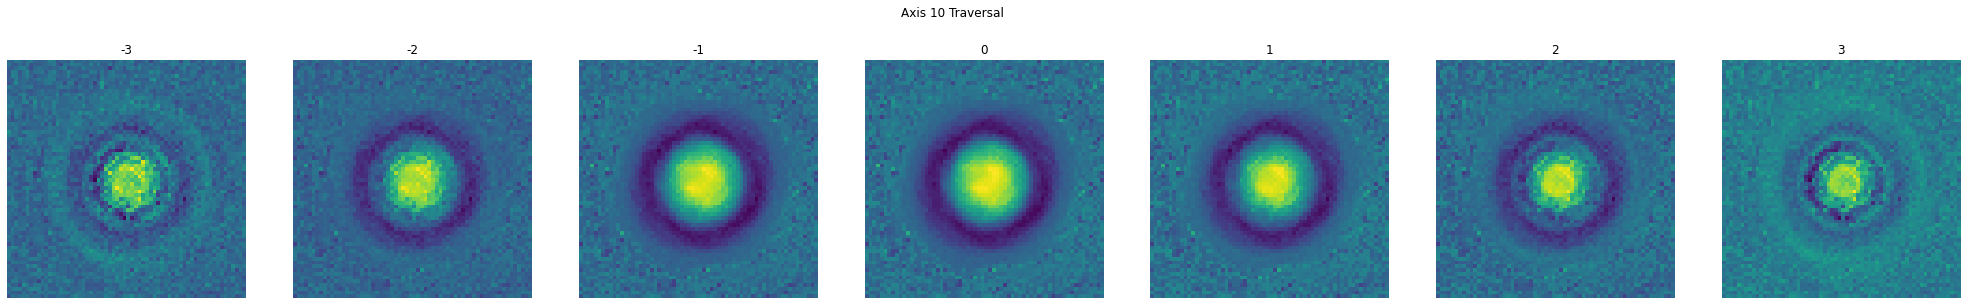

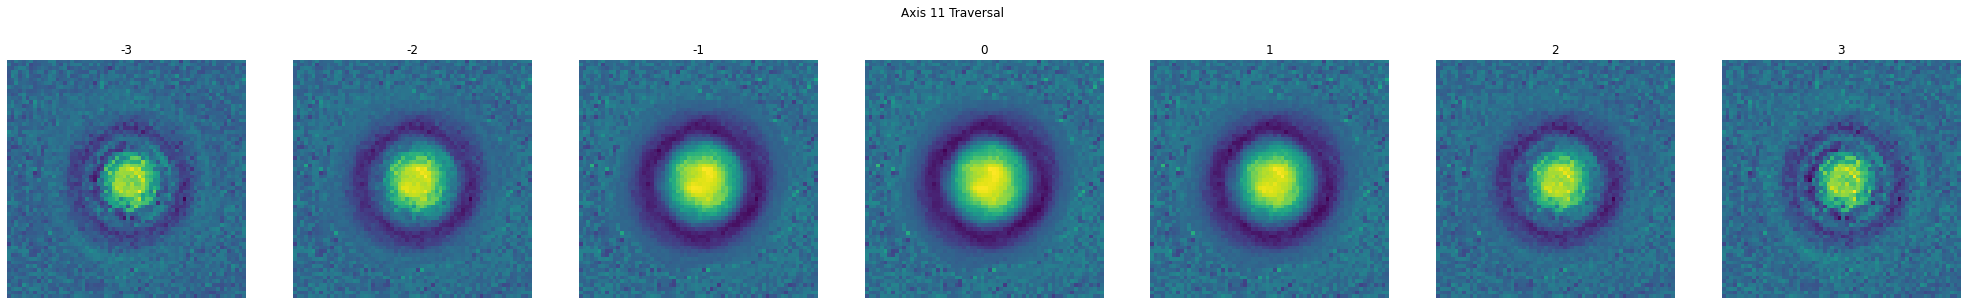

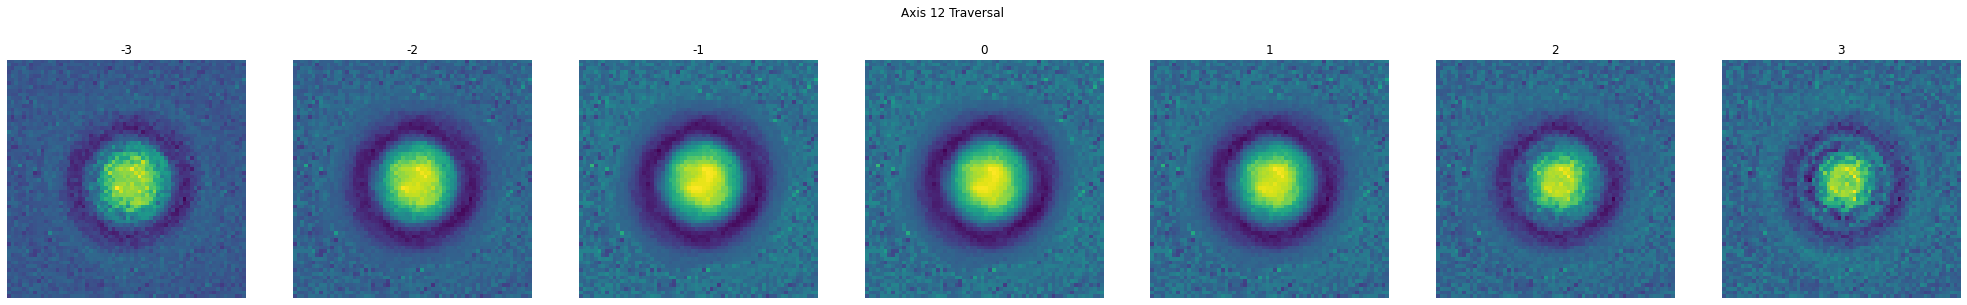

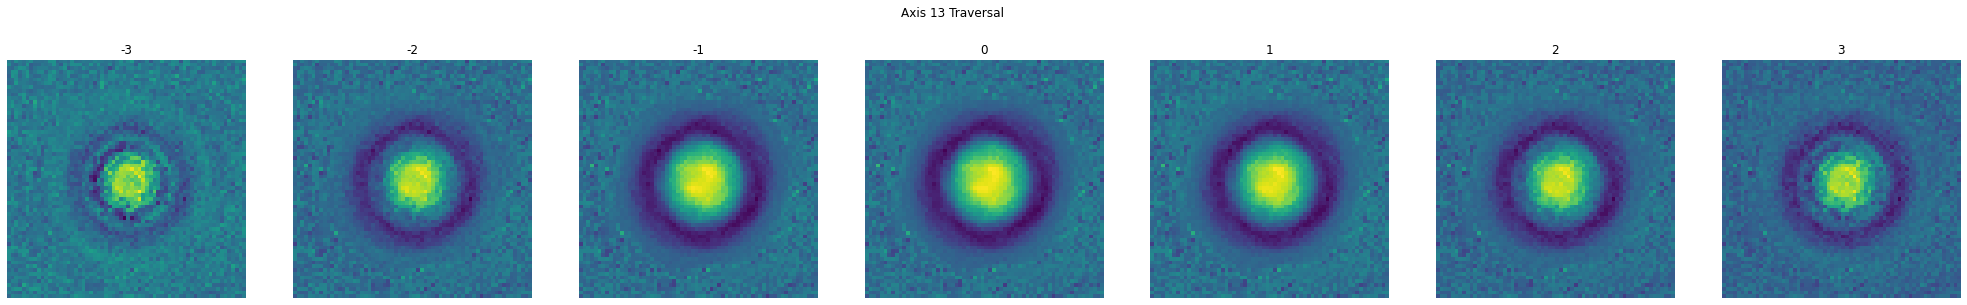

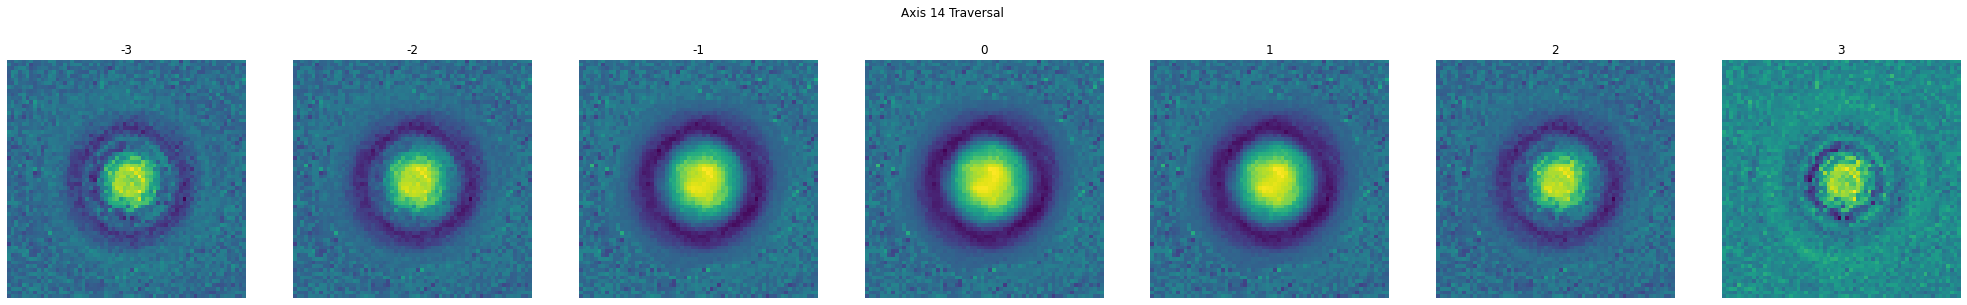

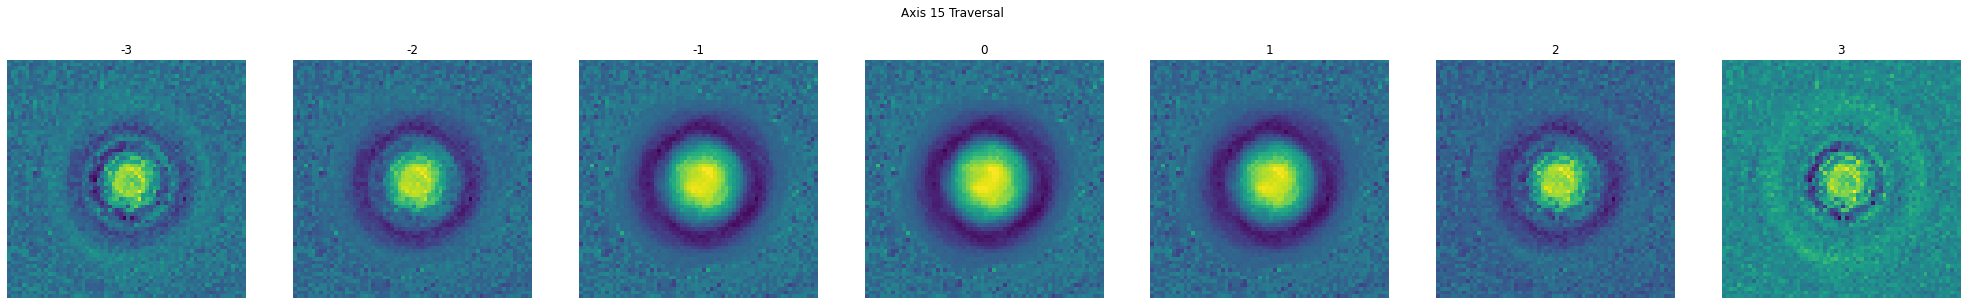

In [43]:
get_axis_trav_recons(img, encoder, decoder)